In [ ]:
!pip install tensorflow

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving tired-man-driving-on-highway-eyes-closes-drop-and-falls-asleep-behind-wheel-lo-SBV-348554928-preview (1).mp4 to tired-man-driving-on-highway-eyes-closes-drop-and-falls-asleep-behind-wheel-lo-SBV-348554928-preview (1).mp4


Loaded images: (4000, 24, 24, 1)
Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.7158 - loss: 0.5533 - val_accuracy: 0.9087 - val_loss: 0.2205
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9422 - loss: 0.1631 - val_accuracy: 0.9525 - val_loss: 0.1433
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9639 - loss: 0.1072 - val_accuracy: 0.9825 - val_loss: 0.0645
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9774 - loss: 0.0689 - val_accuracy: 0.9762 - val_loss: 0.0581
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9815 - loss: 0.0491 - val_accuracy: 0.9875 - val_loss: 0.0477
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9899 - loss: 0.0341 - val_accuracy: 0.9900 - val_loss: 0.0304
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9923 - loss: 0.0265 - val_accuracy: 0.9925 - val_loss: 0.0269
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9967 

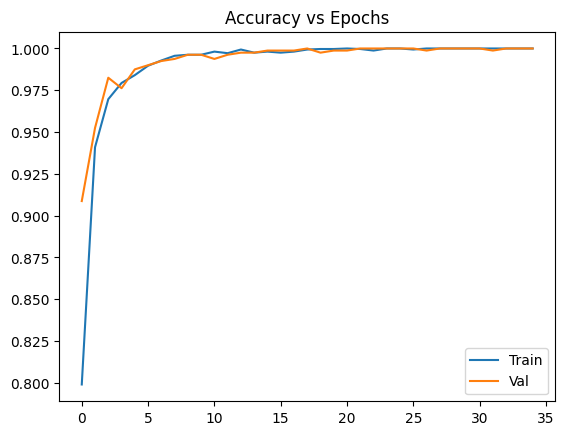

In [ ]:
#  1. Imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

#2. Load Dataset
data_dir = "/content/train"
labels = {'Open_Eyes': 0, 'Closed_Eyes': 1}
X = []
y = []

for label in labels:
    path = os.path.join(data_dir, label)
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, (24, 24))
        X.append(img)
        y.append(labels[label])

X = np.array(X).reshape(-1, 24, 24, 1) / 255.0
y = to_categorical(y, num_classes=2)

print(f"Loaded images: {X.shape}")

# 3. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 4. Build Model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(24,24,1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 5. Train
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, callbacks=[early_stop], batch_size=64)

#  6. Plot
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.legend()
plt.title("Accuracy vs Epochs")
plt.show()

#  7. Test on Video (no webcam)
video_path = "/content/tired-man-driving-on-highway-eyes-closes-drop-and-falls-asleep-behind-wheel-lo-SBV-348554928-preview (1) (1).mp4"
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

cap = cv2.VideoCapture(video_path)
frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_count += 1
    if frame_count % 4 != 0:  # only every 4th frame
        continue

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        roi_face = gray[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_face, 1.1, 4)

        for (ex, ey, ew, eh) in eyes:
            eye = roi_face[ey:ey+eh, ex:ex+ew]
            eye = cv2.resize(eye, (24, 24)).reshape(1, 24, 24, 1) / 255.0
            pred = model.predict(eye, verbose=0)
            label = 'Open' if np.argmax(pred) == 0 else 'Closed'
            color = (0, 255, 0) if label == 'Open' else (0, 0, 255)
            cv2.rectangle(frame, (x+ex, y+ey), (x+ex+ew, y+ey+eh), color, 2)
            cv2.putText(frame, label, (x+ex, y+ey-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Optional: show frame if running locally
    # cv2.imshow('frame', frame)
    # if cv2.waitKey(1) & 0xFF == ord('q'):
    #     break

cap.release()



--- Frame at 20 predictions ---


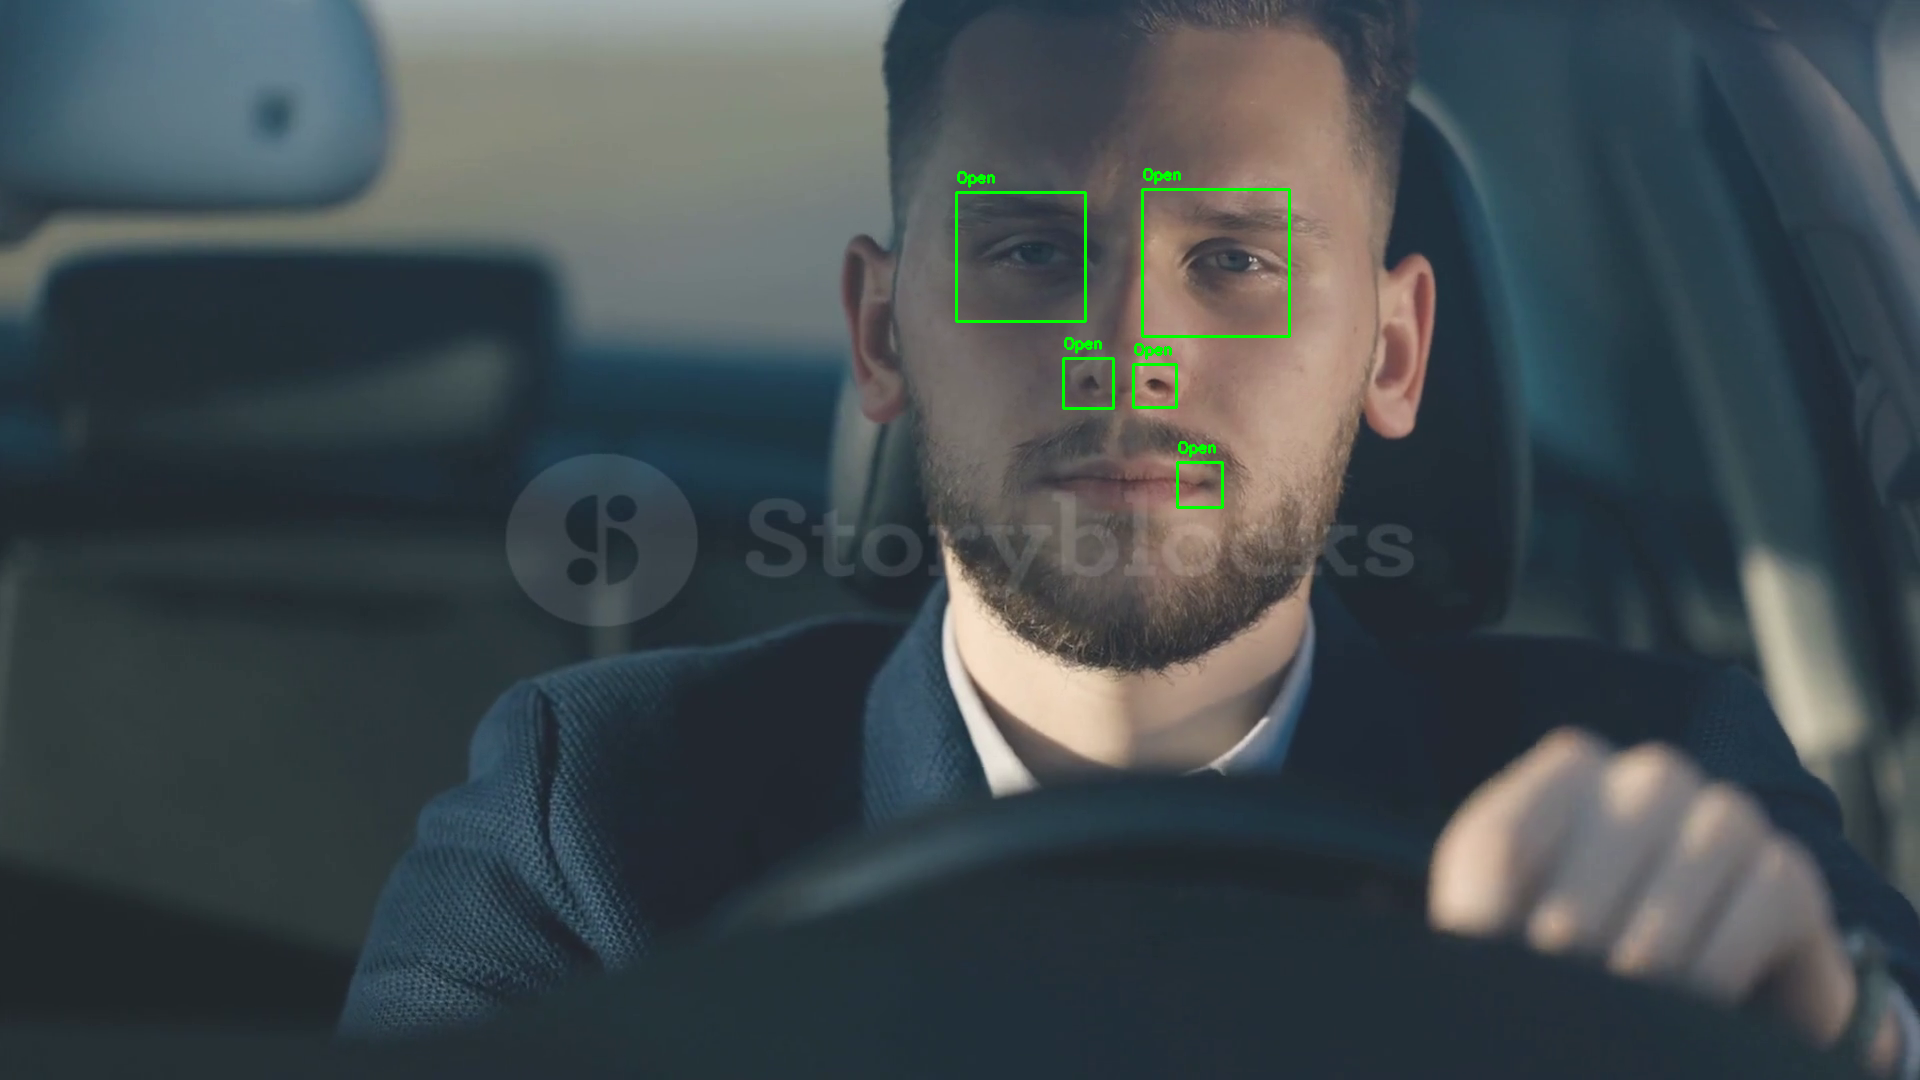

=== Summary ===
Total Eye Predictions: 278
Open Eye Predictions: 241
Closed Eye Predictions: 37
Predicted Open %: 86.69%
Predicted Closed %: 13.31%


In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

# 7. Test on Real Video
video_path = "test_vid.mp4"
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

cap = cv2.VideoCapture(video_path)
frame_count = 0

total_preds = 0
open_preds = 0
closed_preds = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    if frame_count % 4 != 0:  # process every 4th frame
        continue

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        roi_face = gray[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_face, 1.1, 4)

        for (ex, ey, ew, eh) in eyes:
            eye = roi_face[ey:ey+eh, ex:ex+ew]
            eye = cv2.resize(eye, (24, 24)).reshape(1, 24, 24, 1) / 255.0
            pred = model.predict(eye, verbose=0)
            pred_label = np.argmax(pred)

            total_preds += 1
            if pred_label == 0:
                open_preds += 1
            else:
                closed_preds += 1

            # Drawing predictions
            color = (0, 255, 0) if pred_label == 0 else (0, 0, 255)
            label = 'Open' if pred_label == 0 else 'Closed'
            cv2.rectangle(frame, (x+ex, y+ey), (x+ex+ew, y+ey+eh), color, 2)
            cv2.putText(frame, label, (x+ex, y+ey-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    if total_preds in [20, 40, 60, 80, 100]:
        print(f"\n--- Frame at {total_preds} predictions ---")
        cv2_imshow(frame)

cap.release()

# Print summary
print("=== Summary ===")
print(f"Total Eye Predictions: {total_preds}")
print(f"Open Eye Predictions: {open_preds}")
print(f"Closed Eye Predictions: {closed_preds}")
print(f"Predicted Open %: {open_preds / total_preds * 100:.2f}%")
print(f"Predicted Closed %: {closed_preds / total_preds * 100:.2f}%")
